## Code to Chapter 8 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YtDcpgcxgSIJnqNns6fP97Zp3bwMCqUX?usp=sharing)

## Drug Discovery with LangChain and Knowledge Graphs

This notebook demonstrates how to build and query a comprehensive drug discovery knowledge graph using Neo4j and LangChain. We'll explore drug-disease relationships, side effects, pathways, and create intelligent query systems for pharmaceutical research.

## Overview

The notebook covers:
- Setting up a Neo4j graph database with drug discovery data
- Building knowledge graph relationships between drugs, diseases, pathways, and side effects
- Creating intelligent query systems using LangChain's GraphCypherQAChain
- Implementing vector embeddings for semantic search
- Advanced querying techniques for drug discovery insights

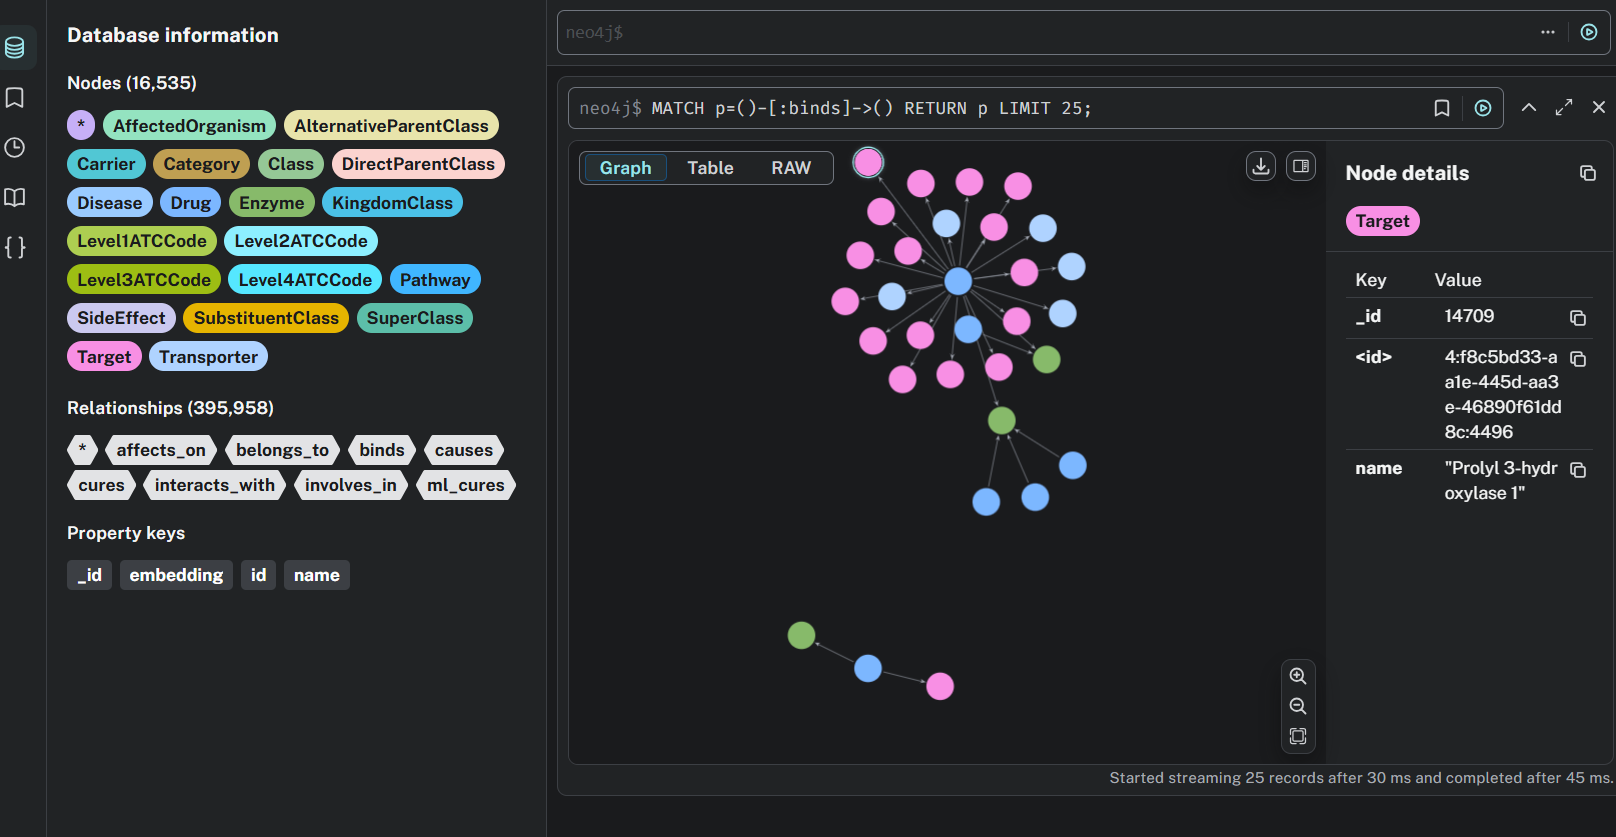

## 1. Environment Setup and Dependencies

First, let's install the required packages for our drug discovery pipeline:

In [1]:
!pip install -q neo4j openai langchain langchain_openai langchain_community langchain_neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
google-genai 1.27.0 requires tenacity<9.0.0,>=8.2.3, but you have tenacity 9.1.2 which is incomp

In [2]:
!pip freeze | grep "langc\|openai\|neo4j"

langchain==0.3.26
langchain-community==0.3.27
langchain-core==0.3.71
langchain-neo4j==0.5.0
langchain-openai==0.3.28
langchain-text-splitters==0.3.8
langcodes==3.5.0
neo4j==5.28.1
neo4j-graphrag==1.9.0
openai==1.97.1


## 2. Data Acquisition

Download the pre-processed drug discovery datasets

**Data Structure:**
- `nodes.json`: Contains entities like drugs, diseases, pathways, side effects, and their properties
- `edges.json`: Contains relationships between entities (e.g., "drug cures disease", "drug causes side effect")

In [3]:
!mkdir data
# edges_file_id = '1XBsVB_i-v1vKWEEGi3mSJgW0yL87XoTH'
# nodes_file_id = '1fb1FUqwjfx6xodjZOgnaJCnpmWOcv_mG'
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={nodes_file_id}' -O data/nodes.json
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={edges_file_id}' -O data/edges.json

!wget https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch8_edges_sm.json -O data/edges.json
!wget https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch8_nodes_sm.json -O data/nodes.json

--2025-07-28 10:24:35--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch8_edges_sm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11104903 (11M) [text/plain]
Saving to: ‘data/edges.json’

data/edges.json     100%[===================>]  10.59M  --.-KB/s    in 0.1s    

2025-07-28 10:24:35 (87.5 MB/s) - ‘data/edges.json’ saved [11104903/11104903]

--2025-07-28 10:24:35--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/main/data/datasets/ch8_nodes_sm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

## 3. Import Libraries and Setup Environment

**Security Note:** We're using Colab's userdata feature to securely store API keys. In production, use environment variables or secure key management systems.

In [4]:
import json
import time
from tqdm import tqdm
import numpy as np
from neo4j import GraphDatabase
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings

In [5]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")
os.environ["NEO4J_CLIENT_ID"] = userdata.get("NEO4J_CLIENT_ID")
os.environ["NEO4J_CLIENT_SECRET"] = userdata.get("NEO4J_CLIENT_SECRET")
os.environ["NEO4J_PASSWORD"] = userdata.get("NEO4J_PASSWORD")

In [6]:
AURA_PATH = "neo4j+s://4c301cbf.databases.neo4j.io"

## 4. Neo4j Database Connection Class

**Key Features:**
- Connection pooling for performance optimization
- Proper session management to prevent memory leaks
- Error handling for robust database operations
- Support for multiple databases

In [7]:
import time
import requests
from requests.auth import HTTPBasicAuth
from neo4j import GraphDatabase, basic_auth, bearer_auth

TOKEN_URL = "https://api.neo4j.io/oauth/token"


class Neo4jConnection:
    def __init__(
        self,
        uri,
        user=None,
        pwd=None,
        client_id=None,
        client_secret=None,
        max_connection_pool_size=100,
    ):
        self.__uri = uri
        self.__driver = None
        self.__auth_mode = None

        if client_id and client_secret:
            self.__auth_mode = "oauth"
            self.__client_id = client_id
            self.__client_secret = client_secret
            self.__access_token = None
            self.__token_expiry = 0
            self.__connect_oauth(max_connection_pool_size)
        elif user and pwd:
            self.__auth_mode = "legacy"
            self.__user = user
            self.__pwd = pwd
            self.__connect_legacy(max_connection_pool_size)
        else:
            raise ValueError(
                "Either (user, pwd) or (client_id, client_secret) must be provided."
            )

    def __connect_legacy(self, pool_size):
        try:
            self.__driver = GraphDatabase.driver(
                self.__uri,
                auth=basic_auth(self.__user, self.__pwd),
                max_connection_pool_size=pool_size,
            )
        except Exception as e:
            print("Failed to create legacy driver:", e)

    def __connect_oauth(self, pool_size):
        try:
            token = self.__get_valid_token()
            self.__driver = GraphDatabase.driver(
                self.__uri, auth=bearer_auth(token), max_connection_pool_size=pool_size
            )
        except Exception as e:
            print("Failed to create OAuth driver:", e)

    def __get_valid_token(self):
        now = time.time()
        if self.__access_token is None or now >= self.__token_expiry:
            try:
                resp = requests.post(
                    TOKEN_URL,
                    auth=HTTPBasicAuth(self.__client_id, self.__client_secret),
                    headers={"Content-Type": "application/x-www-form-urlencoded"},
                    data={"grant_type": "client_credentials"},
                    timeout=10,
                )
                resp.raise_for_status()
                data = resp.json()
                self.__access_token = data["access_token"]
                self.__token_expiry = now + data.get("expires_in", 3600) - 10  # buffer
            except Exception as e:
                print("Failed to get access token:", e)
                raise
        print("Access Token:", self.__access_token)
        return self.__access_token

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            if self.__auth_mode == "oauth":
                # Refresh token if expired
                token = self.__get_valid_token()
                self.__driver = GraphDatabase.driver(
                    self.__uri, auth=bearer_auth(token), max_connection_pool_size=100
                )
            session = (
                self.__driver.session(database=db) if db else self.__driver.session()
            )
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

The following config will be different as you create your own Aura DB

In [8]:
"""
#oauth2
conn = Neo4jConnection(
    uri=AURA_PATH,
    client_id=os.environ["NEO4J_CLIENT_ID"],
    client_secret = os.environ["NEO4J_CLIENT_SECRET"]
)
"""

# legacy user/password
conn = Neo4jConnection(uri=AURA_PATH, user="neo4j", pwd=os.environ["NEO4J_PASSWORD"])

In [9]:
conn

## 5. Graph Construction Mode Configuration

**Mode Options:**
- `"build_graph"`: Loads data from JSON files into Neo4j database
- `"query_graph"`: Queries existing database (use this if data is already loaded)


In [10]:
MODE = "build_graph"
MODE = "query_graph"

## 6. Graph Database Population Functions

These functions handle batch insertion of nodes and relationships

**Batch Processing Benefits:**
- Prevents memory overflow with large datasets
- Improves performance through bulk operations
- Provides progress tracking and statistics


In [11]:
if MODE == "build_graph":
    with open("data/nodes.json", "r") as f:
        nodes = json.load(f)

    with open("data/edges.json", "r") as f:
        edges = json.load(f)

    def insert_data(query, rows, batch_size=10000):
        # Function to handle the updating the Neo4j database in batch mode.

        total = 0
        batch = 0
        start = time.time()
        result = None

        while batch * batch_size < len(rows):
            batch_rows = rows[batch * batch_size : (batch + 1) * batch_size]
            res = conn.query(query, parameters={"rows": batch_rows})
            total += res[0]["total"]
            batch += 1
            result = {"total": total, "batches": batch, "time": time.time() - start}

        return result

    def add_edges(rows, rel_type, batch_size=10000):
        query = (
            """
        UNWIND $rows as row
        MATCH (from {_id:row.from})
        MATCH (to {_id: row.to})
        MERGE (from)-[rel:"""
            + rel_type
            + """]->(to)
        RETURN count(*) as total
        """
        )

        return insert_data(query, rows, batch_size=batch_size)

    def add_nodes(rows, category, batch_size=1000):
        # Adds author nodes to the Neo4j graph as a batch job.
        query = (
            """UNWIND $rows AS row
                  MERGE (:"""
            + category
            + """ {_id:row.id, name: row.name})
                  RETURN count(*) as total
        """
        )
        return insert_data(query, rows, batch_size=batch_size)

## 7. Database Population Process

**What happens here:**
1. **Constraints**: Ensure data integrity by preventing duplicate nodes
2. **Node Creation**: Insert all entities (drugs, diseases, pathways, etc.)
3. **Relationship Creation**: Connect entities with their relationships
4. **Data Cleaning**: Handle special characters in relationship names

In [12]:
if MODE == "build_graph":
    type_set = {nodes[x]["type"] for x in nodes}
    for _t in tqdm(type_set):
        print(_t)
        conn.query(
            f"CREATE CONSTRAINT {_t.lower()} IF NOT EXISTS FOR (d:{_t}) REQUIRE d.id IS UNIQUE"
        )
        add_nodes(
            [
                {"id": int(x), "name": nodes[x]["name"]}
                for x in nodes
                if nodes[x]["type"] == _t
            ],
            _t,
        )

    np_edges = np.array(edges)
    for _t in tqdm(np.unique(np_edges[:, 1])):
        add_edges(
            [
                {
                    "from": int(_t[0]),
                    "rel_type": _t[1].replace("-", "_"),
                    "to": int(_t[2]),
                }
                for _t in np_edges[np_edges[:, 1] == _t]
            ],
            _t.replace("-", "_"),
        )

If you're building the graph provided, it may take up to 1.5 hours!

In [13]:
# conn.close()

## 8. LangChain Integration Setup

**Component Explanation:**
- **Neo4jGraph**: LangChain's interface to Neo4j database
- **OpenAIEmbeddings**: Converts text to vector embeddings for semantic search
- **ChatOpenAI**: Language model for generating Cypher queries and answers
- **structured_schema**: Shows available node types and relationships

In [14]:
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

In [15]:
graph = Neo4jGraph(
    url=AURA_PATH, username="neo4j", password=os.environ["NEO4J_PASSWORD"]
)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")
chat_model = ChatOpenAI(temperature=0)

In [16]:
graph.structured_schema

{'node_props': {'Level3ATCCode': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'Level2ATCCode': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'Enzyme': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'AffectedOrganism': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'KingdomClass': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'SuperClass': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'Disease': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'},
   {'property': 'embedding', 'type': 'LIST'}],
  'Class': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'SubstituentClass': [{'property': 'name', 'type': 'STRING'},
   {'property': '_id', 'type': 'INTEGER'}],
  'Level4ATCCode': [{'p

## 9. Basic Graph Query Chain

**Query Process:**
1. User asks natural language question
2. LLM generates Cypher query
3. Query executes against Neo4j
4. Results are returned and optionally formatted

In [17]:
chain_1 = GraphCypherQAChain.from_llm(
    chat_model,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    return_direct=True,
    allow_dangerous_requests=True,
)

In [18]:
chain_1.invoke({"query": "What category does Fluoxymesterone belong to?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Drug{name:"Fluoxymesterone"})-[:belongs_to]->(c:Category)
RETURN c;

> Finished chain.


{'query': 'What category does Fluoxymesterone belong to?',
 'result': [{'c': {'name': 'Hormones', '_id': 16944}},
  {'c': {'name': 'Hormones, Hormone Substitutes, and Hormone Antagonists',
    '_id': 16946}},
  {'c': {'name': 'Genito Urinary System and Sex Hormones', '_id': 16804}},
  {'c': {'name': 'Fused-Ring Compounds', '_id': 16775}},
  {'c': {'name': 'Steroids', '_id': 18046}},
  {'c': {'name': 'Sex Hormones and Modulators of the Genital System',
    '_id': 18002}},
  {'c': {'name': 'Anabolic Agents', '_id': 15768}},
  {'c': {'name': 'Androgens', '_id': 15777}},
  {'c': {'name': 'Steroids, Fluorinated', '_id': 18048}},
  {'c': {'name': 'Androstanes', '_id': 15781}}],
 'intermediate_steps': [{'query': 'MATCH (:Drug{name:"Fluoxymesterone"})-[:belongs_to]->(c:Category)\nRETURN c;'}]}

In [19]:
chain_1.invoke({"query": "What category does fluoxymesterone belong to?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Drug{name: "fluoxymesterone"})-[:belongs_to]->(c:Category)
RETURN c;

> Finished chain.


{'query': 'What category does fluoxymesterone belong to?',
 'result': [],
 'intermediate_steps': [{'query': 'MATCH (:Drug{name: "fluoxymesterone"})-[:belongs_to]->(c:Category)\nRETURN c;'}]}

In [20]:
chain_1.invoke({"query": "What can cure meningitis?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (d:Drug)-[:cures]->(:Disease{name: "Meningitis"}) RETURN d;

> Finished chain.


{'query': 'What can cure meningitis?',
 'result': [],
 'intermediate_steps': [{'query': 'MATCH (d:Drug)-[:cures]->(:Disease{name: "Meningitis"}) RETURN d;'}]}

In [21]:
chain_1.invoke(
    {"query": "What side effect can be caused by expectorants category drugs?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Category)-[:belongs_to]->(:Drug)-[:causes]->(se:SideEffect)
WHERE se.name = "Expectorants"
RETURN se;

> Finished chain.


{'query': 'What side effect can be caused by expectorants category drugs?',
 'result': [],
 'intermediate_steps': [{'query': 'MATCH (:Category)-[:belongs_to]->(:Drug)-[:causes]->(se:SideEffect)\nWHERE se.name = "Expectorants"\nRETURN se;'}]}

## 10. Enhanced Query Chain with Custom Prompts

**Enhanced Features:**
- **Query Decomposition**: Breaks down complex questions into steps
- **Domain Knowledge**: Includes drug discovery relationship patterns
- **Case Insensitivity**: Handles variations in entity names
- **Fuzzy Matching**: Uses CONTAINS for partial name matches
- **ML Predictions**: Includes machine learning predicted relationships
- **Validation**: Checks Cypher syntax before execution

In [22]:
prompt_graph_schema = f"Nodes: {graph.structured_schema['node_props'].keys()} \nRelationships: {graph.structured_schema['relationships']}".replace(
    "{", "{{"
).replace(
    "}", "}}"
)

In [23]:
prompt_graph_schema

"Nodes: dict_keys(['Level3ATCCode', 'Level2ATCCode', 'Enzyme', 'AffectedOrganism', 'KingdomClass', 'SuperClass', 'Disease', 'Class', 'SubstituentClass', 'Level4ATCCode', 'Transporter', 'AlternativeParentClass', 'DirectParentClass', 'Target', 'Pathway', 'Carrier', 'Category', 'Drug', 'SideEffect', 'Level1ATCCode']) \nRelationships: [{{'start': 'Pathway', 'type': 'belongs_to', 'end': 'Category'}}, {{'start': 'Drug', 'type': 'affects_on', 'end': 'AffectedOrganism'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'Level3ATCCode'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'Level2ATCCode'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'KingdomClass'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'SuperClass'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'Class'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'SubstituentClass'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'Level4ATCCode'}}, {{'start': 'Drug', 'type': 'belongs_to', 'end': 'AlternativeParentClass

In [24]:
from langchain_core.prompts.prompt import PromptTemplate

QA_TEMPLATE = """
Before generating the cypher query, always decompose what the final query should do.
Question: {question}
"""

QA_PROMPT = PromptTemplate(input_variables=["question"], template=QA_TEMPLATE)


CYPHER_GENERATION_TEMPLATE = (
    """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
"""
    + prompt_graph_schema
    + """
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

For complex queries think of the relationships required for execution form the list above.
#What pathways are drugs curing cerebral embolism involved in. To answer this question several steps should be provided:
1. Drug - cures -> Disease
2. Drug - involves_in -> Pathway
MATCH (d:Drug)-[:cures]->(:Disease {{name: 'Cerebral Embolism'}}), (d)-[:involves_in]->(p:Pathway) RETURN p

Always use toLower method to avoid case sensitivity:
#What categories does dornase alfa drug belong to?
MATCH (d:Drug)-[:belongs_to]->(c:Category) WHERE toLower(d.name) CONTAINS('dornase alfa') return d, c
#List steroid drugs
MATCH (d:Drug)-[:belongs_to]->(c:Category) WHERE toLower(c.name) CONTAINS('steroids') return d, c

As some of the nodes as Disease and SideEffect may have multiple concatenated values, always use contain statement:
# What drugs cause osteomalacia?
MATCH (d:Drug)-[:causes]->(s:SideEffect) WHERE toLower(s.name) CONTAINS('osteomalacia') return d, s

One of the relationships is ml_cures - predicted cure by a drug to certain disease. If the question suggests possible
predicted cure as well, include ml_cures relationship:
# What drugs potentially can cure burns?
MATCH (drug:Drug)-[:cures]->(disease:Disease)
OPTIONAL MATCH (drug:Drug)-[:ml_cures]->(disease:Disease)
WHERE toLower(disease.name) CONTAINS 'burn'
RETURN drug, disease

The question is:
{question}"""
)

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["question"], template=CYPHER_GENERATION_TEMPLATE
)

chain_2 = GraphCypherQAChain.from_llm(
    chat_model,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    return_direct=True,
    validate_cypher=True,
    use_function_response=True,
    qa_prompt=QA_PROMPT,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
)

## 11. Testing Enhanced Queries

**Expected Behavior:**
- More accurate Cypher generation
- Better handling of medical terminology
- Inclusion of both confirmed and predicted relationships

In [25]:
chain_2.invoke({"query": "What can cure meningitis?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (drug:Drug)-[:cures]->(disease:Disease)
WHERE toLower(disease.name) CONTAINS 'meningitis'
RETURN drug, disease

> Finished chain.


{'query': 'What can cure meningitis?',
 'result': [{'drug': {'name': 'Sulfisoxazole', '_id': 163},
   'disease': {'name': 'Meningococcal meningitis',
    '_id': 100342,
    'embedding': [-0.004470575600862503,
     0.006195382680743933,
     0.002341638086363673,
     0.01992422714829445,
     0.023776037618517876,
     0.03731151670217514,
     -0.026746109127998352,
     0.042230699211359024,
     0.024611370638012886,
     0.014061430469155312,
     -0.029839932918548584,
     -0.018532006070017815,
     0.014734337106347084,
     0.017124315723776817,
     0.003267851658165455,
     0.027798008173704147,
     0.005162818823009729,
     -0.005186022724956274,
     0.01987781934440136,
     0.03799216076731682,
     0.0386728011071682,
     -0.01797511801123619,
     0.007595337927341461,
     0.02948414348065853,
     0.013171955943107605,
     0.022244594991207123,
     0.011725593358278275,
     0.014773009344935417,
     0.03780652955174446,
     0.03384643420577049,
     -0.0231

In [26]:
chain_2.invoke(
    {"query": "What side effect can be caused by expectorants category drugs?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (d:Drug)-[:belongs_to]->(c:Category {name: 'Expectorants'})<-[:belongs_to]-(d)-[:causes]->(s:SideEffect) RETURN s

> Finished chain.


{'query': 'What side effect can be caused by expectorants category drugs?',
 'result': [],
 'intermediate_steps': [{'query': "MATCH (d:Drug)-[:belongs_to]->(c:Category {name: 'Expectorants'})<-[:belongs_to]-(d)-[:causes]->(s:SideEffect) RETURN s"}]}

## 12. Vector Search Setup

**Vector Search Benefits:**
- **Semantic Understanding**: Finds related concepts, not just exact matches
- **Fuzzy Matching**: Handles typos and variations in medical terms
- **Ranked Results**: Returns similarity scores for relevance
- **Domain Flexibility**: Works with synonyms and related medical conditions

In [27]:
graph.query("""SHOW VECTOR INDEXES""")

[{'id': 42,
  'name': 'vectorDiseases',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'VECTOR',
  'entityType': 'NODE',
  'labelsOrTypes': ['Disease'],
  'properties': ['embedding'],
  'indexProvider': 'vector-2.0',
  'owningConstraint': None,
  'lastRead': neo4j.time.DateTime(2025, 7, 28, 10, 23, 8, 981000000, tzinfo=<UTC>),
  'readCount': 16}]

In [28]:
graph_with_vectors = Neo4jVector.from_existing_graph(
    embedding=embedding_model,
    url=AURA_PATH,
    username="neo4j",
    password=os.environ["NEO4J_PASSWORD"],
    index_name="vectorDiseases",
    node_label="Disease",
    text_node_properties=["name"],
    embedding_node_property="embedding",
)

In [29]:
graph_with_vectors.similarity_search_with_score("meningitis", k=5)

[(Document(metadata={'_id': 100342}, page_content='\nname: Meningococcal meningitis'),
  0.8133172988891602),
 (Document(metadata={'_id': 100962}, page_content='\nname: Neonatal meningitis'),
  0.801633358001709),
 (Document(metadata={'_id': 100687}, page_content='\nname: Staphylococcal meningitis'),
  0.7988214492797852),
 (Document(metadata={'_id': 100344}, page_content='\nname: Meningococcemia'),
  0.7916450500488281),
 (Document(metadata={'_id': 100686}, page_content='\nname: Streptococcal meningitis'),
  0.7908687591552734)]

In [30]:
retriever = graph_with_vectors.as_retriever()
retriever.invoke("What can cure meningitis?")

[Document(metadata={'_id': 100687}, page_content='\nname: Staphylococcal meningitis'),
 Document(metadata={'_id': 100686}, page_content='\nname: Streptococcal meningitis'),
 Document(metadata={'_id': 100342}, page_content='\nname: Meningococcal meningitis'),
 Document(metadata={'_id': 100962}, page_content='\nname: Neonatal meningitis')]

In [31]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, verbose=True)

cypher_chain = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_requests=True,
)


def hybrid_graph_chain(query: str):
    print("\n🔎 User Query:", query)

    # 1. Retrieve similar relationship concepts
    similar_contexts = retriever.invoke(query)
    similar_texts = [doc.page_content for doc in similar_contexts]
    print("\n🔍 Similar Concepts from Neo4jVector:")
    for t in similar_texts:
        print("-", t)

    # 2. Enrich query with similar terms
    enriched_query = f"{query}\n\nRelated concepts: {', '.join(similar_texts)}"

    # 3. Run the Cypher chain with enriched query
    result = cypher_chain.invoke({"query": enriched_query})

    # 4. Print results
    print("\n🧠 Final Answer:\n", result["result"])

    return result

In [32]:
result = hybrid_graph_chain("What can cure meningitis?")


🔎 User Query: What can cure meningitis?

🔍 Similar Concepts from Neo4jVector:
- 
name: Staphylococcal meningitis
- 
name: Streptococcal meningitis
- 
name: Meningococcal meningitis
- 
name: Neonatal meningitis


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (d:Drug)-[:cures]->(disease:Disease)
WHERE disease.name IN ['Staphylococcal meningitis', 'Streptococcal meningitis', 'Meningococcal meningitis', 'Neonatal meningitis']
RETURN d.name

Full Context:
[{'d.name': 'Sulfisoxazole'}, {'d.name': 'Ceftazidime'}, {'d.name': 'Cefotaxime'}, {'d.name': 'Meropenem'}, {'d.name': 'Benzylpenicillin'}, {'d.name': 'Chloramphenicol'}, {'d.name': 'Cefotaxime'}, {'d.name': 'Ceftizoxime'}, {'d.name': 'Meropenem'}, {'d.name': 'Benzylpenicillin'}]

> Finished chain.

🧠 Final Answer:
 Sulfisoxazole, Ceftazidime, Cefotaxime, Meropenem, Benzylpenicillin, Chloramphenicol, and Ceftizoxime can be used to cure meningitis.


In [33]:
result

{'query': 'What can cure meningitis?\n\nRelated concepts: \nname: Staphylococcal meningitis, \nname: Streptococcal meningitis, \nname: Meningococcal meningitis, \nname: Neonatal meningitis',
 'result': 'Sulfisoxazole, Ceftazidime, Cefotaxime, Meropenem, Benzylpenicillin, Chloramphenicol, and Ceftizoxime can be used to cure meningitis.',
 'intermediate_steps': [{'query': "cypher\nMATCH (d:Drug)-[:cures]->(disease:Disease)\nWHERE disease.name IN ['Staphylococcal meningitis', 'Streptococcal meningitis', 'Meningococcal meningitis', 'Neonatal meningitis']\nRETURN d.name\n"},
  {'context': [{'d.name': 'Sulfisoxazole'},
    {'d.name': 'Ceftazidime'},
    {'d.name': 'Cefotaxime'},
    {'d.name': 'Meropenem'},
    {'d.name': 'Benzylpenicillin'},
    {'d.name': 'Chloramphenicol'},
    {'d.name': 'Cefotaxime'},
    {'d.name': 'Ceftizoxime'},
    {'d.name': 'Meropenem'},
    {'d.name': 'Benzylpenicillin'}]}]}

## Bonus: Relationship Embeddings (not avaialble on AURA Free tier)

**Relationship Embeddings Enable:**
- Semantic search over relationship types
- Finding similar relationship patterns
- Advanced graph neural network applications
- More sophisticated recommendation systems

In [34]:
create_rel_embeddings = False

In [35]:
if create_rel_embeddings:
    relations_embedding = {}
    for r_type in graph.query("""CALL db.relationshipTypes()"""):
        relations_embedding[r_type["relationshipType"]] = embedding_model.embed_query(
            " ".join(r_type["relationshipType"].split("_"))
        )

    for r_type in relations_embedding:
        print(f"Processing {r_type} relationships...")
        query_match = f"MATCH ()-[r:{r_type}]->() RETURN r"
        query_update = f"WITH r SET r.embedding = {relations_embedding[r_type]}"
        graph.query(
            f"""
            CALL apoc.periodic.iterate(
                "{query_match}",
                "{query_update}",
                {{batchSize: 500, parallel: true}})
        """
        )

In [36]:
if create_rel_embeddings:
    try:
        dimension = 1536
        similarity_function = "cosine"

        cypher_query = f"""
        CREATE VECTOR INDEX name IF NOT EXISTS
        FOR ()-[r:REL_TYPE]-() ON (r.embedding)
        OPTIONS {{
          indexConfig: {{
            `vector.dimensions`: {dimension},
            `vector.similarity_function`: "{similarity_function}"
          }}
        }}
        """

        graph.query(cypher_query)

    except:
        print("You are most probably on AURA Free Tier")

## 14. Summary and Key Insights

This notebook demonstrates a complete pipeline for drug discovery knowledge graphs:

### **Technical Achievements:**
1. **Scalable Data Loading**: Batch processing for large pharmaceutical datasets
2. **Intelligent Querying**: Natural language to Cypher translation
3. **Semantic Search**: Vector embeddings for fuzzy matching
4. **Domain Expertise**: Drug discovery specific prompt engineering

### **Research Applications:**
- **Drug Repurposing**: Find existing drugs for new diseases
- **Side Effect Analysis**: Identify potential adverse reactions
- **Pathway Research**: Explore drug mechanisms of action
- **Drug Interactions**: Discover potentially harmful combinations

### **Next Steps:**
- Implement drug recommendation systems
- Add temporal analysis for drug development timelines
- Include clinical trial data integration
- Develop drug similarity networks

### **Performance Considerations:**
- Use connection pooling for concurrent users
- Implement caching for frequent queries
- Consider read replicas for heavy analytical workloads
- Monitor query performance and optimize indexes

---

## Sample Queries You Can Try

```python
# Disease treatment discovery
"What drugs can treat Alzheimer's disease?"

# Side effect analysis
"Which drugs cause liver toxicity?"

# Drug categorization
"List all antibiotics in the database"

# Pathway exploration
"What pathways are involved in cancer treatment?"

# Drug interactions
"Which drugs interact with warfarin?"

# Predictive queries
"What diseases might aspirin potentially treat?"
```

This knowledge graph approach provides a powerful foundation for pharmaceutical research, drug discovery, and clinical decision support systems.